<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;" >Classification naïve bayésienne pour des données à multi-labels</div>

Dans ce notebook, nous nous intéresserons au problème de classification d'un jeu de données possédant plusieurs labels. La méthode présentée ici est tirée de l'article "Naive Bayes Classification for Subset Selection" co-écrit par Luca MOSSINA et Emmanuel RACHELSON.
    
Lien de l'article : https://arxiv.org/abs/1707.06142

Les librairies suivantes sont nécessaires au bon déroulement du notebook. Elles ont normalement toutes été déjà utilisées et ne devraient pas nécessiter d'installation particulière.

In [348]:
from sys import path

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.stats import norm

from sklearn import datasets
from sklearn.utils import shuffle

# 1. <a id="sec1"></a>Présentation du problème

Prenons un exemple simple afin d'illustrer dans quel cas nous pouvons avoir à faire à ce type de problème de classification à multi-labels. 

Imaginons que nous souhaitions mettre en relation les préférences culinaires des invités pour un repas avec notre liste de course afin de réaliser un gateau. L'ensemble des éléments achetables représentent les différents labels qui prennent la valeur 1 si il faut les acheter et 0 sinon. C'est un problème de classification à multi-labels. On notera $L$ l'ensemble des labels.

Un des aspects clés à visualiser ici est que  la valeur d'un label peut être conditionnellement dépendante de la valeur des autres. En effet dans l'exemple, il est préférable que la liste de course permette de réaliser un seul gateau plutôt que de contenir un mélange de deux recettes. Il faudra prendre cela en compte lors de l'évaluation des méthodes prochainement décrites.

<div class="alert alert-success">
    
**Différence avec la classification multi-classe**.<br>
La classification multi-classe ne concerne les cas où il n'y a qu'un seul label, ($L$ contient donc un seul élément) et où ce label peut prendre plus de deux valeurs.
</div>

Ainsi le sujet se détache du cas canonique, ce dernier ayant pour but de calculer un classifieur $f$  qui à chaque vecteur d'observation $x$ associe la classe $c\in C$ la plus probable. On a alors : $f : X \to C$ comme dans la figure ci-dessous.

<img src='img/fig1.png'>

Cependant, un problème de classification multi-labels peut être vu comme un problème de classification multi-classe. Notons $L$ l'ensemble des  labels où chacun de ses éléments peut prendre la valeur $0$ ou $1$. Cette fois-ci nous considérons que $C=P(L)$ avec $P(L)$ l'ensemble des parties de $L$, $f$ s'écrit alors $f : X \to C=P(L)$. 

<img src='img/fig3.png'>

<img src='img/fig2.png'>

Ce problème pourrait être résolu avec des méthodes de classification classiques comme la classification naïve bayésienne. Cependant, la taille de l'ensemble $P(L)$ augmente exponentiellement avec le nombre de labels. On a $|C| = 2^{|L|}$. Cette méthode ne peut donc pas être utilisable à partir d'un certain nombre de labels du fait de la complexité spatiale trop importante.

Afin de passer outre cette limitation, la méthode présentée dans ce notebook suivra l'architecture suivante :

+ pour une observation $x$ donnée, on détermine la taille $m$ du sous-ensemble des labels
+ on détermine le premier label non-nul sachant $x$ et $m$
+ on détermine un à un les labels non-nuls en prenant en compte $x$, $m$ et les labels précedemment trouvés 

La prise en compte des derniers labels trouvés à chaque nouvelle itération offre la possibilité de gérer la dépendance conditionnelle  que nous avons abordée plus haut qui peut exister entre les labels.

Afin de réaliser cette algorithme, une **cascade de classifieur** (où le classifieur $k$ prédit le $k$-ème élément) est utilisée. On supposera que chacun de ces classifieurs sera un **classifeur naïf bayésien**.

Nous verrons que cette approche conduit à une diminution remarquable de la complexité (en temps et en espace) de la classification multi-labels. 

# 2. <a id="sec2"></a>Rappel sur la classification naïve bayésienne

Dans cette partie, nous nous replaçons dans le cas canonique. On considère un vecteur d'observation $x = (x_1, ...,x_n)$ appartenant à $\mathbb{R}^{n}$ et on cherche à estimer la loi de probabilité $\mathbb{P}(C|X)$. On s'intéresse donc au terme suivant :
$$\mathbb{P}(C=c|X=x)$$

Le classifieur $f$ retourne la classe $c$ qui maximise le terme précédent :
$$f = \arg\max_{c} \mathbb{P}(C=c|X=x)$$
D'après le théorème de Bayes, on obtient :
$$\mathbb{P}(C=c|X=x) =\frac{\mathbb{P}(X=x|C=c)\cdot\mathbb{P}(C=c)}{\mathbb{P}(X=x)}$$

L'**hypothèse naïve bayésienne** consiste à considérer que $X_1,..., X_n$ sont indépendantes. On a alors :
\begin{align*}
\arg\max_{c} \mathbb{P}(C=c|X=x) & = \arg\max_{c} \frac{\prod\limits_{i=1}^n \mathbb{P}(X_i=x_i|C=c) \mathbb{P}(C=c)}{\mathbb{P}(X=x)}\\
& = \arg\max_{c} \prod\limits_{i=1}^n \mathbb{P}(X_i=x_i|C=c) \mathbb{P}(C=c)\\
\end{align*}

L'hypothèse courante est ensuite de considérer que les lois $(X_i|C)$ suivent une loi gaussienne. On peut alors estimer les paramètres de ces lois à l'aide du jeu de données initiale et réaliser la classification.

Pour exemple, le jeu de donnée vu en cours est utilisé. Les données correspondent à trois données corporelles (taille, poids et taille de pieds), le label correspond au sexe de la personne (1 si c'est un homme, 0 si c'est une femme).

In [2]:
data = np.loadtxt("sex_classif.csv")
data

array([[ 0.  ,  1.82, 82.  , 30.  ],
       [ 0.  ,  1.8 , 86.  , 28.  ],
       [ 0.  ,  1.7 , 77.  , 30.  ],
       [ 0.  ,  1.8 , 75.  , 25.  ],
       [ 1.  ,  1.52, 45.  , 15.  ],
       [ 1.  ,  1.65, 68.  , 20.  ],
       [ 1.  ,  1.68, 59.  , 18.  ],
       [ 1.  ,  1.75, 68.  , 23.  ],
       [ 1.  ,  1.58, 49.  , 19.  ]])

In [8]:
# Estimation des paramètres des lois gaussiennes pour les hommes
dataM = data[data[:,0]==0]
mu_HS0 = np.mean(dataM[:,1])
std_HS0 = np.std(dataM[:,1])
mu_WS0 = np.mean(dataM[:,2])
std_WS0 = np.std(dataM[:,2])
mu_FS0 = np.mean(dataM[:,3])
std_FS0 = np.std(dataM[:,3])
pS0 = dataM.shape[0]/data.shape[0]

# Estimation des paramètres des lois gaussiennes pour les femmes
dataF = data[data[:,0]==1]
mu_HS1 = np.mean(dataF[:,1])
std_HS1 = np.std(dataF[:,1])
mu_WS1 = np.mean(dataF[:,2])
std_WS1 = np.std(dataF[:,2])
mu_FS1 = np.mean(dataF[:,3])
std_FS1 = np.std(dataF[:,3])
pS1 = dataF.shape[0]/data.shape[0]

# classification pour le vexteur x (taille=1.81,poids=59,taille de pieds=21) 
H=1.81
W=59
F=21

score_M = pS0 * norm.pdf(H,mu_HS0,std_HS0) * norm.pdf(W,mu_WS0,std_WS0) * norm.pdf(F,mu_FS0,std_FS0)
score_F = pS1 * norm.pdf(H,mu_HS1,std_HS1) * norm.pdf(W,mu_WS1,std_WS1) * norm.pdf(F,mu_FS1,std_FS1)
print("score male    :", score_M)
print("score female  :", score_F)
print("proba male    :", score_M/(score_M+score_F))
print("proba female  :", score_F/(score_M+score_F))

score male    : 6.981284895980458e-10
score female  : 0.0012161942837264688
proba male    : 5.740267802562792e-07
proba female  : 0.9999994259732197


**Complexité spatiale** :
Afin de comprendre pourquoi il ne serait pas raisonnable de réaliser une classification multi-labels en utilisant une classification naïve bayésienne, il faut encore regarder du côté de la complexité spatiale. 

Dans le cas canonique avec l'hypothèse de loi gaussienne, la classification consiste à estimer et stocker $|C| - 1$ valeurs pour décrire $\mathbb{P}(C)$ (dans l'exemple $|C| = 2$) et $2n|C|$ valeurs pour estimer tous les $\mathbb{P}(X_i|C)$ (le facteur $2$ correspond aux paramètres nécessaires -moyenne et variance- pour décrire une loi gaussienne).

Revenons dans le cas multi-labels, nous avons vu que ce genre de problème est assimilable à un problème multi-classe et que dans ce cas $|C|=2^{|L|}$. L'espace nécessaire pour réaliser une classification naïve serait en $O(2n2^{|L|})$. Par exemple, pour un jeu de données avec 10 paramètres $X_i$ suivant une loi gaussienne et 100 labels, la complexité spatiale serait de l'ordre de $10^{31}$. 

# 3. <a id="sec3"></a>Classification multi-labels 

Dans cette partie, nous allons voir différentes méthodes d'approche du problème de classification multi-labels avant de se concentrer sur la méthode présentée dans l'article : l'algorithme NaiBX (Naive Bayes Classification for Subset Selection) qui utilise une cascade de classifieurs. 

Leur point commun est l'utilisation d'un **méta-classifieur** qui à chaque étape d'incrémentation définit un classifieur qui aura pour objectif de déterminer le prochain label qui sera non-nul. Le classifieur retourne le même type vecteur que le classifieur qui assimilait la classification multi-labels  à une classification multi-classes : la liste des labels non nuls.

## 3.1 <a id="sec3.1"></a>Chaine de classifieurs

L'algorithme commence d'abord par prédire si le label $l_1$ est inclus dans le vecteur de sortie en prenant en compte le jeu de donnée $X$ initiale. Il fait de même pour $l_2$ en prenant en compte cette fois $X$ et le fait que $l_1$ appartienne ou pas au vecteur de sortie. On note $Y_i$ appartenant à {$0,1$} la variable décrivant si le label $l_i$ est dans le vecteur de sortie et $h_i$ le classifieur à $i$-ème itération.

Nous avons donc à l'étape $i$ : 
$$Y_i = h_i(X|Y_{i-1},..., Y_1)$$

Sans entrer dans les détails de comment sont calculés les $Y_i$, une première limite de cette méthode provient de l'influence importance donnée à l'ordre des labels sur lesquels opèrent les classifieurs successifs. Réaliser un ECC (Ensemble of Classifier Chains) peut permettre de contourner ce problème. Il s'agit de réaliser $k$ différents méta-classifieurs sur des permutations aléatoires des labels. Par exemple, on pourrait avoir $h^{1}(Y_1, Y_2, Y_3)$, $h^{2}(Y_2, Y_1, Y_3)$, $h^{3}(Y_1, Y_3, Y_2)$...

## 3.2 <a id="sec3.2"></a>Cascade de classifieurs

Une autre approche pourrait consister à commencer par déterminer la taille du sous-ensemble de labels à sélectionner, choir un label dans $L$, en sélectionner un deuxième en prenant en celui précedemment sélectionné et continuer ainsi jusqu'à obtenir le bon nombre de labels.

Cette approche se distingue de la chaine des classifieurs par le fait que les labels ne sont pas sélectionnés de manière incrémentale en les regardant les uns après les autres. Cette architecture ne repose donc pas sur un ordre pré-établi parmi les labels.

On note $Y$ la variable aléatoire qui retourne le vecteur qui devrait être associé à l'observation $x$, $\overline{y}$ (avec $\overline{y}= (y_1, ..., y_k)$ ) sont les observations de $Y$. On rappelle que le classifieur $s$ peut s'écrire :
$$ s(x) = \arg\max_{\overline{y} \in P(L)}\mathbb{P}(Y=\overline{y}|X=x)$$

Nous allons réaliser un travail préliminaire afin de réécrire la probabilité décrite dans la formule précédente. On note $M$ la variable aléatoire décrivant la taille de Y, soit le nombre de labels non-nuls. Nous avons donc équivalence entre les ensembles suivants :
+ " $\overline{y}\subset Y, M=k$" 
+ "$y_1\in Y, ..., y_k\in Y, M = k$" 
+ "$\overline{y}=Y$"

Nous avons donc : 
$$\mathbb{P}(Y=\overline{y}|X=x)= \mathbb{P}(M=m|X=x)\mathbb{P}(\overline{y}\in{Y}|X=x, M=m)$$


Par la suite nous introduisons la notation suivante :

<img src='img/fig4.png'>

On obtient alors en appliquant la formule des probabilités composées :

<img src='img/fig5.png'>

La fomule précédente est celle que va optimiser le classifieur $s$. Comme on le voit dans l'expression suivante, on peut séparer le problème en plusieurs étapes de classification imbriqué les uns dans les autres. Le premier cherche d'abord à déterminer la taille $M$ du vecteur de sortie(= le nombre de labels non nuls) puis détermine à chaque étape un nouveau label qui sera sélectionné jusqu'à en avoir choisi $m$ différents. Il y a donc $m+1$ classifieurs prenant en compte le résultat des précédents pour réaliser sa tâche. Cette architecture correspond à **une cascade de classifieurs**.

<img src='img/fig6.png'>

Jusqu'ici, nous n'avons pas spécifié quel type de classifieurs est utilisé à chaque étape. N'importe quel classifieur pourrait faire l'affaire en théorie, cependant on risque de se retrouver une nouvelle fois bloqué par la complexité spatiale. En effet, la recherche opérée par les derniers classifieurs peut se révéler trop complexe et couteuse en temps de calcul.

## 3.3 <a id="sec3.2"></a>Cascade de classifieurs naïfs bayésiens 

Nous allons désormais sélectionner comme classifieur de base des classifieurs naïfs bayésiens . Ce choix va conduire a une réduction significative de la complexité de l'algorithme globale. 

Considérons le k-ème classifieur de la cascade, avec les hypothèses bayésiennes il se décompose comme suit :


<img src='img/fig7.png'>

Le classifieur calcule alors chacun des termes du produit précédent. 

Lorsque l'on prend deux classifieurs différents $f_k$ et $f_{k'}$, on s'aperçoit qu'il cherche à approximer les mêmes probabilités génériques : $\mathbb{P}(y\in Y)$, $\mathbb{P}(M|Y)$ et $\mathbb{P}(X_i|Y)$. Cette propriété simplifie grandement la quantité d'informations à compiler à chaque itération et permet donc d'appliquer cette méthode sur des cas concrets.

# 4. <a id="sec3"></a>Algorithme NaiBX

Les sections précédentes nous ont donc permis de clarifier trois concepts :

+ La décomposition d'un problème de classification multi-labels en une suite de problèmes de classification à un seul label, cette architecture se nomme une **cascade** et permet de prendre en compte la **relation de dépendance** entre les labels.
+ Il reste malgré tout compliquer d'appliquer cette méthode dans des cas avec de nombreux labels du fait de la complexité des calculs que doivent réaliser les derniers classifieurs de la cascade
+ L'utilisation de classifieurs naïfs bayésiens permet de contourner ce problème en limitant les informations à compiler à chaque fois.

Dans cette partie, nous allons coder l'algorithme NaiBX à partir d'un cas simple avec un jeu de donnée à 2 paramètres et 2 labels afin d'illustrer son fonctionnement. 

L'architecture de l'algorithme ainsi que les variables nécessaires à son écriture sont décrites dans les figures suivantes. Dans un premier, nous générerons un jeu de donnée sur lequel on utilisera l'algorithme. Nous écrirons ensuite les fonctions qui permettront de calculer les paramètres ci-dessous. Enfin, nous écrirons la fonction **predict** qui prend en entrée un vexteur $x_{new}$ qui associera les labels correspondant.

<img src='img/fig8.png'>

La fonction **predict_y** calcule d'abord le nombre $m$ de labels non-nuls grâce à la fonction **predict_m**. Dans un second, elle estime les éléments du vecteur de sortie à travers la cascade de classifieur. A chaque nouvelle itération, elle fait appel à la fonction **predict_yk** qui prend en entrée $x_{new}$ et les labels déjà calculés.

<img src='img/fig9.png'>

<img src='img/fig10.png'>

On commence par générer le jeu de donnée. On considère un jeu de donnée à 200 observations de 2 paramètres auxquelles sont associés deux labels $0$ et $1$. 

In [320]:
import math


n_samples = 100
n_labels = 2
labels = [0, 1]
n_features = 2

X1, y1 = datasets.make_gaussian_quantiles(cov=3.0, n_samples=n_samples, n_features=n_features, n_classes=1)
X1[:,0] = 10 + X1[:,0]
X1[:,1] = 10. + X1[:,1]

X2, y2 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=n_samples, n_features=n_features, n_classes=1)
X2[:,0] = 10. + X2[:,0]
X2[:,1] = 5. + X2[:,1]/2
Xa = np.concatenate((X1, X2))
ya = np.concatenate((y1, - y2 + 1))

Xa, ya = shuffle(Xa, ya)

Xblue = Xa[ya==0]
Xred = Xa[ya==1]

Xyellow = Xa[np.where(Xa[:,0] > 10)]
Xgreen = Xa[np.where(Xa[:,0] <= 10)]


datalabel2 = np.zeros((n_samples*2))
for i in ((np.where(Xa[:,0] > 10))[0]) :
    datalabel2[i] = 1
    
dataset = np.zeros((2*n_samples, 4))
dataset[:, 2:] = Xa
dataset[:, 0] = ya
dataset[:, 1] = datalabel2


print(dataset[:10])

[[ 0.          1.         10.15605056  8.19256906]
 [ 0.          1.         10.85759364 11.25795186]
 [ 1.          0.          8.66277658  5.05635024]
 [ 1.          1.         10.74438814  4.80415207]
 [ 0.          1.         10.98047311 10.32151765]
 [ 0.          1.         10.55736315 11.86632717]
 [ 1.          1.         10.12317111  4.66640976]
 [ 0.          0.          8.73366433 12.43152301]
 [ 1.          1.         10.36943206  4.93425269]
 [ 1.          0.          8.75666221  4.8432248 ]]


Les deux premières du dataset correspondent aux labels et les deux autres aux paramètres.

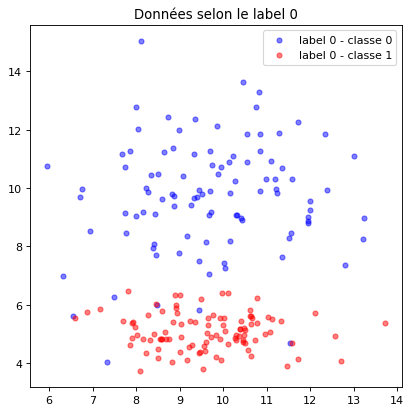

In [322]:
#Affichage pour le label 0

fig=plt.figure(figsize=(6,6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20, alpha=0.5, label='label 0 - classe 0')
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20, alpha = 0.5, label='label 0 - classe 1');
plt.title("Données selon le label 0")
plt.legend()

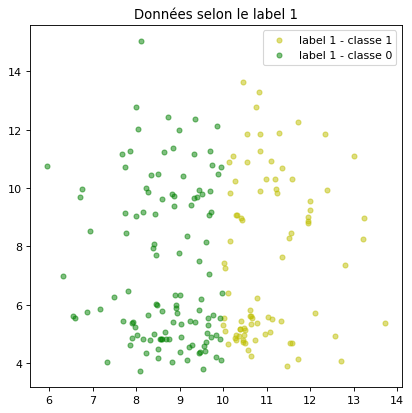

In [323]:
#Affichage pour le label 1
fig=plt.figure(figsize=(6,6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xyellow[:,0],Xyellow[:,1],c='y',s=20, alpha=0.5, label='label 1 - classe 1')#, edgecolors='k')
plt.scatter(Xgreen[:,0],Xgreen[:,1],c='g',s=20, alpha = 0.5, label='label 1 - classe 0');
plt.title("Données selon le label 1")
plt.legend()

In [334]:
#calcule le nombre de fois que le label i vaut 1
def label_occurency(label) :
    return np.where(dataset[:,label]==1)[0].shape[0]

#calcule le nombre de fois qu'il y k labels valant 1
def m_estimator(k) :
    return np.where(dataset[:,0]+dataset[:,1]==k)[0].shape[0]

#Calcule la moyenne d'une feature pour les données pour lesquelles le label sélectionné vaut 1
def meanPxiY(label, feature) :
    data = dataset[dataset[:,label]==1]
    return np.mean(data[:, feature+2])

#Calcule la variance d'une feature pour les données pour lesquelles le label sélectionné vaut 1
def stdPxiY(label, feature) :
    data = dataset[dataset[:,label]==1]
    return np.std(data[:, feature+2])

#Calcule la moyenne d'une feature pour les données pour lesquelles il y a m label(s) valant 1
def meanPxiM(m, feature) :
    data = dataset[dataset[:,0]+dataset[:,1]==m]
    return np.mean(data[:, feature+2])

#Calcule la variance d'une feature pour les données pour lesquelles il y a m label(s) valant 1
def stdPxiM(m, feature) :
    data = dataset[dataset[:,0]+dataset[:,1]==m]
    return np.std(data[:, feature+2])

#calcule le nombre de fois que le label1 et label2 valent 1 sur une même donnée
def label_label_occurency(label1, label2) :
    return np.where(dataset[:,label1]+dataset[:,label2]==2)[0].shape[0]

#calcule le nombre de fois que le label1 vaut 1 avec m labels valant 1 sur une même donnée
def m_label_occurency(label, m) :
    return (np.where((dataset[:,0]+dataset[:,1]==m) & (dataset[:,label]==1))[0].shape[0])

In [339]:
from scipy.stats import norm

#Calcule la taille du vecteur de sortie de la fonction predict
#La taille correspond correspond au nombre de labels de classe non-nulle
#Prend en entrée la nouvelle observation à classifier
def predict_m(x_new) :
    
    best_score = 0
    best_m = 0
    
    for m in range(3) :
        score = m_estimator(m)/(2*n_samples)
        for feature in range(n_features) :
            d = norm.pdf(x_new[feature],meanPxiM(m, feature), stdPxiM(m,feature))
            score *= d
        if (score > best_score) :
            best_score = score
            best_m = m
            
    return best_m

#Calcule le nouveau label considéré à la k-ème itération
#Prend en entrée la nouvelle observation à classifier, la taille m du vecteur final et la liste yf des labels déjà sélectionnées 
def predict_yk(x_new,m, yf) :
    
    best_score = 0
    best_y = 0
    remaining_labels = np.delete(labels, yf)
    
    for y in remaining_labels :
        Py = label_occurency(y)/(2*n_samples)
        score = Py
        for feature in range(n_features) :
            d = norm.pdf(x_new[feature],meanPxiY(y, feature), stdPxiY(y,feature))
            score *= d
            
        Pmy = m_label_occurency(y,m)/label_occurency(y)
        score *= Pmy
        for y_f in yf :
            P = label_label_occurency(y, y_f)/label_occurency(y)
            score *= P
            
        if (score > best_score) :
            best_score = score
            best_y = y
            
    return best_y
        
#Retourne le vecteur finale, y correspond aux labels dont la classe vaut 1, ceux qui ne sont pas dedans valent 1
#On réalise m itérations afin de calculer les m labels de classe non-nulles
def predict(x_new) :
    m = predict_m(x_new)
    y = []
    for k in range (m) :
        yk = predict_yk(x_new,m, y)
        y.append(yk)
    return y

Prenons les observations [9,5], [11,4], [10,10], [8,12] et [9,10] qui au vu des graphes devraient couvrir les 4 cas possibles dans cette exemple :

+ [9,5] >> label 0 = 1 et label 1 = 0
+ [11,4] >> label 0 = 1 et label 1 = 1
+ [10,10] >> label 0 = 0 et label 1 = 1
+ [8,11] >> label 0 = 0 et label 1 = 0

In [340]:
predict([9,5])  #OK, on rappelle que le résultat affiché correspond aux labels valant 1

[0]

In [342]:
predict([11,4]) #OK

[1, 0]

In [344]:
predict([10,10]) #OK

[1]

In [346]:
predict([8,11])  #OK

[]

# 4. <a id="sec3"></a>Conclusion

Dans ce notebook, nous avons abordé le problème de la classification pour des données associées à plusieurs labels. Nous avons vu qu'afin de le résoudre, une approche avec l'élaboration d'un méta-classifieur est nécessaire mais que celle-ci ne suffit pas à elle-seule pour résoudre le problème sous-jacent de la complexité spatiale trop importante pour espèrer résoudre des problèmes réelles. C'est pour cela qu'un **méta-classifieur** avec des **classifieurs naïfs bayésiens** comme classifieur de base avec une **architecture en cascade** a été proposé : l'algorithme NaiBX.

Une rapide introduction par le biais d'un exemple simple a permis de montrer ses principes de base et son implémentation. Afin d'aller plus loin, nous aurions pu observer son comportement sur un jeu de données plus conséquent avec plus de labels notamment. On aurait pu alors confirmer son effectivité pour la réalisation d'une classification multi-labels.